In [1]:
!pip install tensorflow_datasets==4.9.3 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 75.0 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteRL2IDU/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteRL2IDU/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpnjirvz8vtfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

In [5]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = input_mask - 1 # convert to zero based indexing
    return input_image, input_mask

def load_train_images(sample):
    # resize the image
    input_image = tf.image.resize(sample['image'], (128, 128))
    input_mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
    # data augmentation
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    # normalize the images
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_test_images(sample):
    # resize the image
    input_image = tf.image.resize(sample['image'], (128, 128))
    input_mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
    # normalize the images
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [7]:
train_dataset = dataset['train'].map(load_train_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = dataset['test'].map(load_test_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [9]:
def display_sample(image_list):
    plt.figure(figsize=(10,10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(image_list[i]))
        plt.axis('off')

    plt.show()

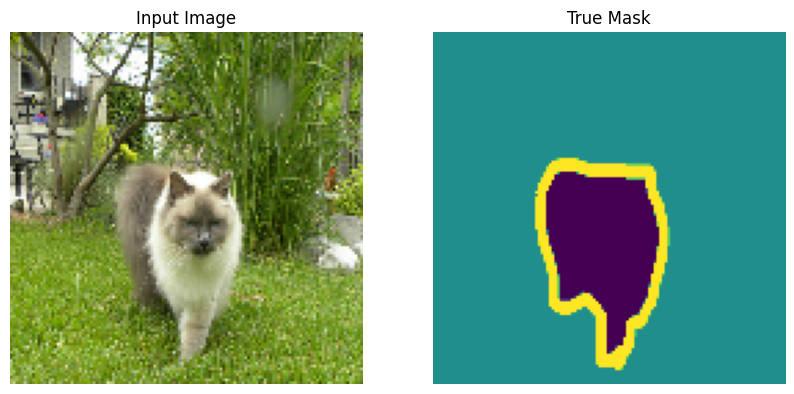

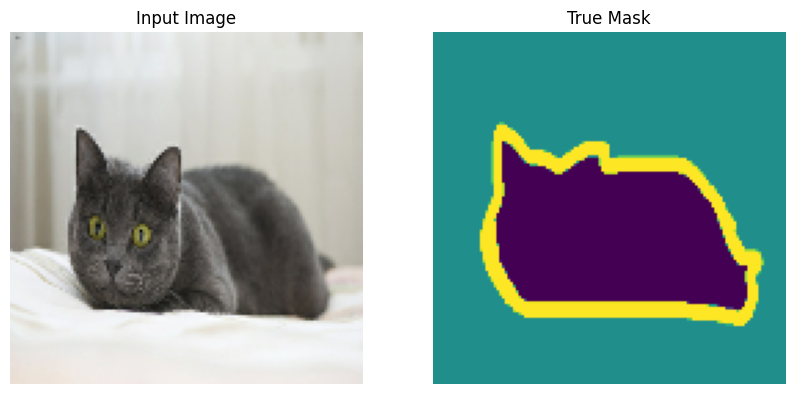

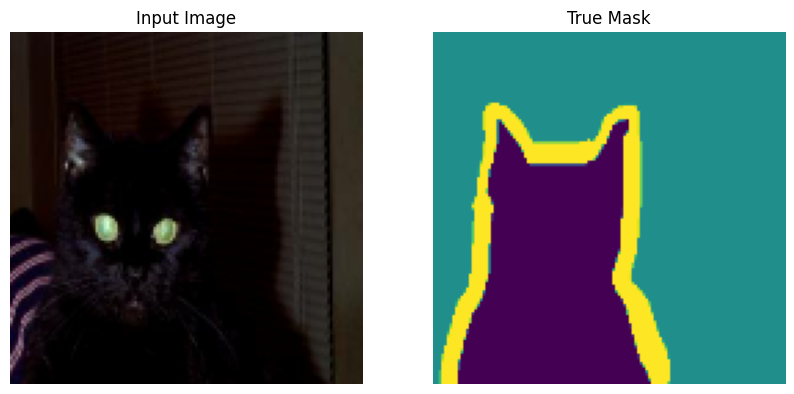

In [10]:
for images, masks in train_dataset.take(3):
    sample_image, sample_mask = images[0], masks[0]
    display_sample([sample_image, sample_mask])

In [11]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [12]:
def build_unet_model(output_channels):
    # input layer
    inputs = layers.Input(shape=(128, 128, 3))

    # encoder - downsample
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # intermediate block
    intermediate_block = double_conv_block(p4, 1024)

    # decoder - upsample
    u6 = upsample_block(intermediate_block, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # output layer
    outputs = layers.Conv2D(output_channels, 1, padding='same', activation='softmax')(u9)

    # unet model
    unet_model = tf.keras.Model(inputs, outputs, name='U-Net')

    return unet_model

In [13]:
output_channels = 3
model = build_unet_model(output_channels)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
!apt-get update && apt-get install graphviz -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,801 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,587 kB]
Get:13 https://r2u.stat.illinois.edu

In [18]:
EPOCHS = 8
steps_per_epoch = info.splits['train'].num_examples // BATCH_SIZE
validation_steps = info.splits['test'].num_examples // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, validation_data=test_dataset)

Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8444 - loss: 0.3799 - val_accuracy: 0.8478 - val_loss: 0.3748
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8507 - loss: 0.3650 - val_accuracy: 0.8379 - val_loss: 0.4013
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8497 - loss: 0.3661 - val_accuracy: 0.8495 - val_loss: 0.3745
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8573 - loss: 0.3475 - val_accuracy: 0.8582 - val_loss: 0.3480
Epoch 5/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8615 - loss: 0.3359 - val_accuracy: 0.8426 - val_loss: 0.4087
Epoch 6/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8643 - loss: 0.3309 - val_accuracy: 0.8611 - val_loss: 0.3424
Epoch 7/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8696 - loss: 0.3150 - val_accuracy: 0.8624 - val_loss: 0.3474
Epoch 8/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8690 - loss: 0.3184 - val_accuracy: 0.8680 - val_loss: 0.3335


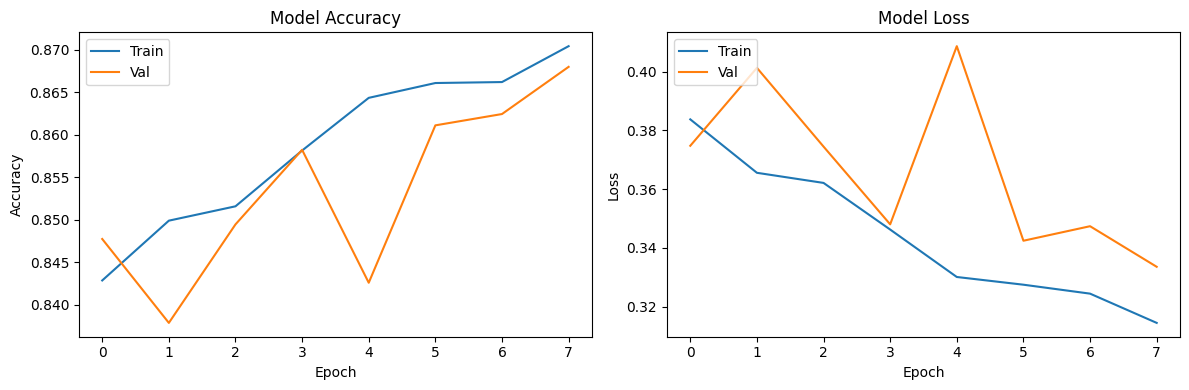

In [19]:
# plot train & val accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

# plot train & val loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [20]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask)])

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step


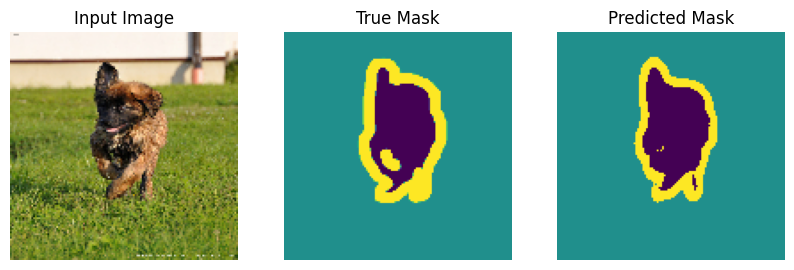

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


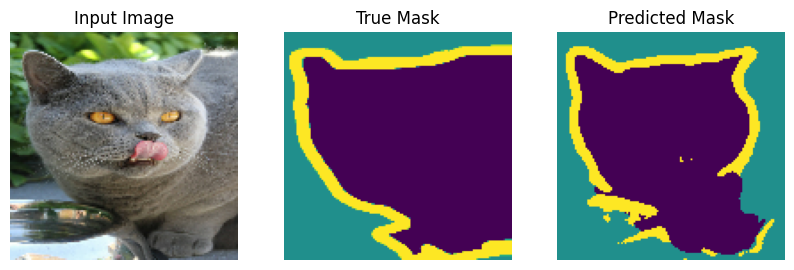

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


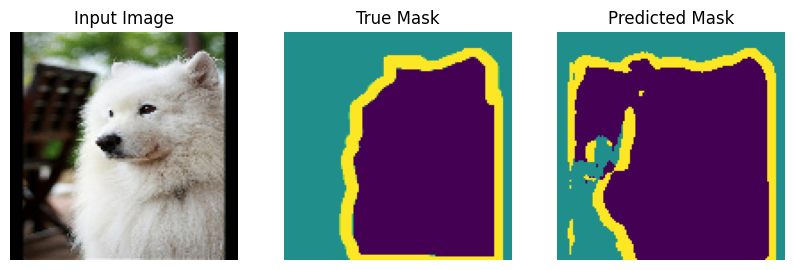

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


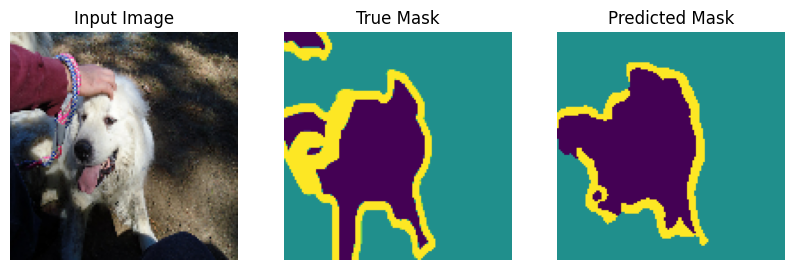

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


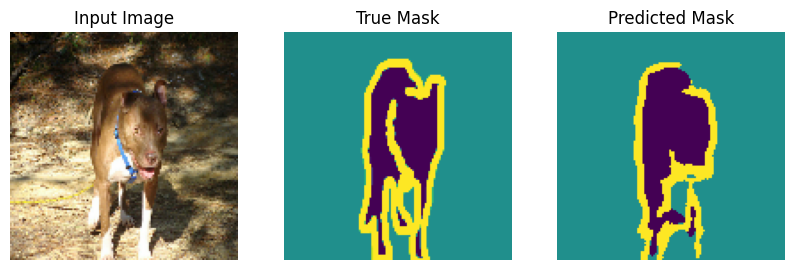

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


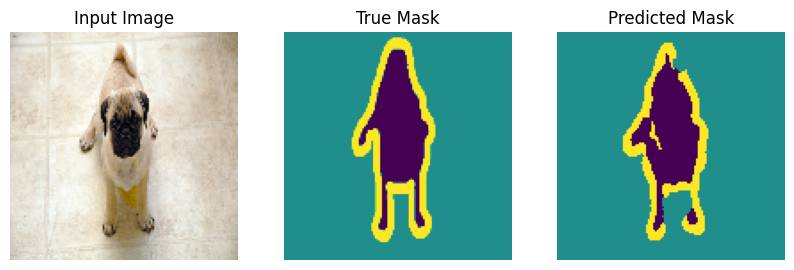

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


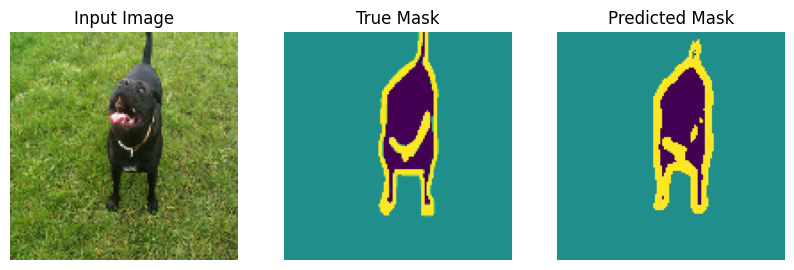

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


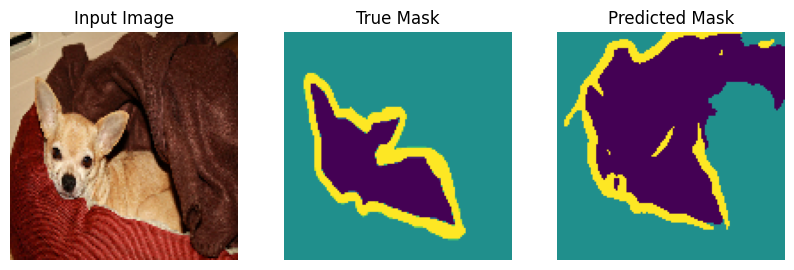

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


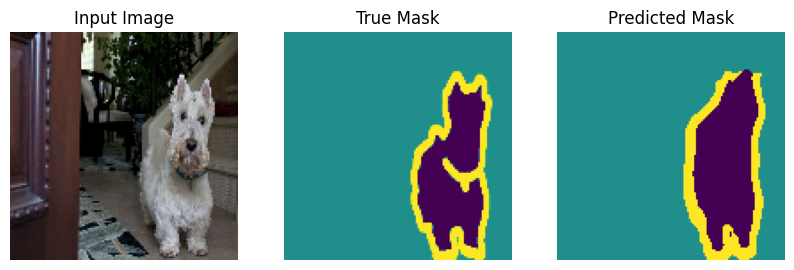

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


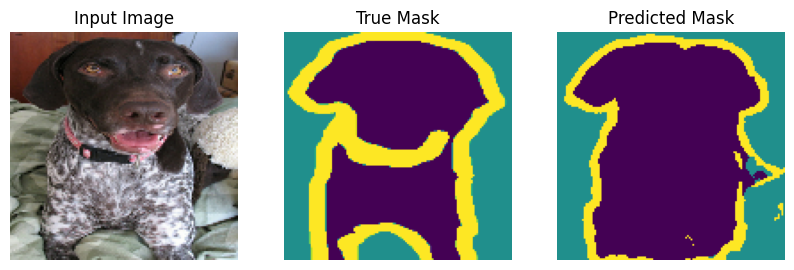

In [21]:
show_predictions(test_dataset, 10)